<a href="https://colab.research.google.com/github/achaudhury7378/IE-643-Implementation/blob/main/C3POs_Code_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [ ]:
import argparse
import copy
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import pickle


# Utility functions to be used

In [ ]:
#####################################################################################################
## Print table of zeros and non-zeros count of a model (Useful to check params alive after pruning)
#####################################################################################################
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))


##############################################################
## Function to reset a model to its original initializations
##############################################################
def original_initialization(mask_temp, initial_state_dict):
    global model
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

        

#####################################################################
## Checks of the directory exist and if not, creates a new directory
#####################################################################
def checkdir(directory):
            if not os.path.exists(directory):
                os.makedirs(directory)

#FIXME 
def plot_train_test_stats(stats,
                          epoch_num,
                          key1='train',
                          key2='test',
                          key1_label=None,
                          key2_label=None,
                          xlabel=None,
                          ylabel=None,
                          title=None,
                          yscale=None,
                          ylim_bottom=None,
                          ylim_top=None,
                          savefig=None,
                          sns_style='darkgrid'
                          ):

    assert len(stats[key1]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key1, len(stats[key1]), epoch_num)
    assert len(stats[key2]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key2, len(stats[key2]), epoch_num)

    plt.clf()
    sns.set_style(sns_style)
    x_ticks = np.arange(epoch_num)

    plt.plot(x_ticks, stats[key1], label=key1_label)
    plt.plot(x_ticks, stats[key2], label=key2_label)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if title is not None:
        plt.title(title)

    if yscale is not None:
        plt.yscale(yscale)

    if ylim_bottom is not None:
        plt.ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)

    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fancybox=True)

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    else:
        plt.show()

# Defining FC1 architecture with 10 neurons in last layer



In [ ]:
class fc1(nn.Module):

    def __init__(self, num_classes = 10):
        super(fc1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Defining the Training and Testing Modules

In [ ]:
#######################################   
# Function for Training
#######################################
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()         ## Clear out the gradients from the last step (otherwise we’d just accumulate the gradients from all loss.backward() calls)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()         ## computes the derivative of the loss w.r.t. the parameters using backpropagation.

    ## Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()              ##  causes the optimizer to take a step based on the gradients of the parameters
    return train_loss.item()

#######################################
# Function for Testing
#######################################
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()   ## sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]                        ## get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Defining the Prune_by_percentile module

In [ ]:
#######################################
# Prune by Percentile module
#######################################
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        step = 0
        
        for name, param in model.named_parameters():

        ## Note: We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)]         ## flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)   ## Calculating percentile value

            ## Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
            ## Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

# Defining the function for Weight Initialization

In [ ]:
#######################################
# Function for Initialization
#######################################
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)



# Main procedure: 

In [ ]:

## Main
writer = SummaryWriter()

def main(args, ITE=0):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reinit = True if args.prune_type=="reinit" else False
    
    #################
    ## Data Loader
    #################
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
    
    ##########################################
    ## Loading the MNIST dataset
    ##########################################
    if args.dataset == "mnist":
        traindataset = datasets.MNIST('../data', train = True, download = True, transform = transform)
        testdataset = datasets.MNIST('../data', train=False, transform = transform)

    train_loader = torch.utils.data.DataLoader(traindataset, batch_size = args.batch_size, shuffle = True, num_workers = 0, drop_last = False)
    test_loader = torch.utils.data.DataLoader(testdataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, drop_last = True)
    
    #########################################
    # Importing Network Architecture
    #########################################
    global model
    if args.arch_type == "fc1":
        model = fc1().to(device)
    elif args.arch_type == "lenet5":
        model = LeNet5().to(device)

    ####################################
    # Weight Initialization
    ####################################
    model.apply(weight_init)

    ###########################################
    ## Copying and Saving Initial State
    ###########################################
    initial_state_dict = copy.deepcopy(model.state_dict())
    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
    torch.save(model, f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/initial_state_dict_{args.prune_type}.pth.tar")

    ############################
    ## Making Initial Mask
    ############################
    make_mask(model)

    ###########################
    ## Optimizer and Loss
    ###########################
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()         ## Default was F.nll_loss
    
    #######################
    ## Layer Looper
    #######################
    for name, param in model.named_parameters():
        print(name, param.size())

    #########################################################
    ## Pruning
    ## NOTE: First Pruning Iteration is of No Compression
    ##########################################################
    best_accuracy = 0                     ## Variable for storing Best accuracy observed in each prune iteration
    ITERATION = args.prune_iterations     ## No. of Prune iterations as put in argument while calling
    comp = np.zeros(ITERATION,float)      ## Array for storing % weights left after pruning in each prune iteration
    bestacc = np.zeros(ITERATION,float)   ## Array for storing Best accuracy in each prune iteration 
    step = 0
    all_loss = np.zeros(args.end_iter,float)      ## Array for storing loss in each training iteration
    all_accuracy = np.zeros(args.end_iter,float)  ## Array for storing accuracy in each training iteration
    all_masks = []


    for _ite in range(args.start_iter, ITERATION):      ## Iterating over no. of prune iterations
        all_masks.append(mask)    ## Keeping track of all the masks obtained from each pruning iteration
        if not _ite == 0:      ## So that in the very first iteration, 100% of the weights remain
            prune_by_percentile(args.prune_percent, resample = resample, reinit = reinit)

            if reinit:                     ## If weights are set to re-initialization
                model.apply(weight_init)   ## Weight initialized using "weight_init" fn.
                step = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)   ## Applying the mask over the set of parameters
                        step = step + 1
                step = 0
            
            else:                       ## If weights are NOT set to re-initialization
                original_initialization(mask, initial_state_dict)      ## Applying mask over set of parameters set of original initialization
            
            optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
        
        print("\n")
        print(f" \n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")
        
        #########################################################
        ## Print the table of Nonzeros in each layer of a model
        #########################################################
        comp1 = print_nonzeros(model)
        comp[_ite] = comp1
        pbar = tqdm(range(args.end_iter))

        for iter_ in pbar:     ## Iterating over training iterations in each prune iteration
            ################################
            ## Frequency for Testing
            ################################
            if iter_ % args.valid_freq == 0:
                accuracy = test(model, test_loader, criterion)

                ###################
                ## Save Weights
                ###################
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                    torch.save(model,f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{_ite}_model_{args.prune_type}.pth.tar") 
            
            ###################
            ## Training
            ###################
            loss = train(model, train_loader, optimizer, criterion)
            all_loss[iter_] = loss
            all_accuracy[iter_] = accuracy
            # print(f"\nTrain epoch: {iter_} | All_accuracy: {all_accuracy} |  accuracy at that epoch: {accuracy}")
            # print(f"\nTrain epoch: {iter_} | All_loss: {all_loss} | accuracy at that epoch: {loss}")

            ###############################################
            # Frequency for Printing Accuracy and Loss
            ###############################################
            if iter_ % args.print_freq == 0:
                pbar.set_description(
                    f'Train Epoch: {iter_}/{args.end_iter} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       

        writer.add_scalar('Accuracy/test', best_accuracy, comp1)
        bestacc[_ite] = best_accuracy    ## Storing the Best Accuracies obtained in each pruning iteration

        ########################################################################################################################################################################################################
        ## Plotting Loss (Training), Accuracy (Testing), Iteration Curve
        ## NOTE: Loss is computed for every iteration while Accuracy is computed only for every {args.valid_freq} iterations. Therefore Accuracy saved is constant during the uncomputed iterations.
        ## NOTE: Normalized the accuracy to [0,100] for ease of plotting.
        ########################################################################################################################################################################################################
        plt.plot(np.arange(1,(args.end_iter)+1), 100*(all_loss - np.min(all_loss))/np.ptp(all_loss).astype(float), c="blue", label="Loss") 
        plt.plot(np.arange(1,(args.end_iter)+1), all_accuracy, c="red", label="Accuracy") 
        Loss.append(100*(all_loss - np.min(all_loss))/np.ptp(all_loss))
        Accuracies.append(all_accuracy)
        Iters.append(args.end_iter)
        Comps.append(comp1)
        plt.title(f"Loss Vs Accuracy Vs Iterations ({args.dataset},{args.arch_type})") 
        plt.xlabel("Iterations") 
        plt.ylabel("Loss and Accuracy") 
        plt.legend() 
        plt.grid(color="gray") 
        checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
        plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_LossVsAccuracy_{comp1}.png", dpi=1200) 
        plt.close()

    ## Setting the variables back to 0 for the next iteration
        best_accuracy = 0
        all_loss = np.zeros(args.end_iter,float)
        all_accuracy = np.zeros(args.end_iter,float)

    ######################
    ## Plotting 
    ######################
    prune_iterations = np.arange(args.prune_iterations)                       ## Gives the range till number of prune_iterations
    plt.plot(prune_iterations, bestacc, c="blue", label="Winning tickets")    ## Plotting the Best test accuracies at each prune iterations
    plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
    plt.xlabel("Unpruned Weights Percentage") 
    plt.ylabel("Test Accuracy") 
    plt.xticks(prune_iterations, comp, rotation ="vertical") 
    plt.ylim(0,100)
    plt.legend() 
    plt.grid(color="gray") 
    checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
    plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
    plt.close() 


    ###########################################################################
    ## Finding the best winning ticket (with highest test accuracy)
    ###########################################################################
    
    best_model_acc_iter = 1+np.argmax(bestacc[1:])             ## Prune iteration for which the model gave best accuracy, giving us the winning ticket
    best_model = torch.load(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{best_model_acc_iter}_model_{args.prune_type}.pth.tar")
    best_model_test_accuracies = Accuracies[best_model_acc_iter] 

    return (best_model, best_model_test_accuracies, prune_iterations, comp, bestacc)                   



############################################################################
# Function to make an empty mask of the same size as the model
############################################################################
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0



if __name__=="__main__":
    class data():
        def __init__(self, lr=1.2e-3, batch_size=60, start_iter=0, end_iter=50, print_freq=10, valid_freq=1, resume=True, prune_type="lt", gpu="0", dataset="mnist", arch_type="fc1", prune_percent=50, prune_iterations=10):
          self.lr=lr
          self.batch_size=batch_size
          self.start_iter=start_iter
          self.end_iter=end_iter
          self.print_freq=print_freq
          self.valid_freq=valid_freq
          self.resume=resume
          self.prune_type=prune_type
          self.gpu=gpu
          self.dataset=dataset
          self.arch_type=arch_type
          self.prune_percent=prune_percent
          self.prune_iterations=prune_iterations

    args = data()


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu
    
    
    #FIXME resample
    resample = False

    ##################################################################################
    ## Creating empty lists to store the required entries in the __main__ function
    ##################################################################################
    Loss=[]
    
    Accuracies=[]
    Iters=[]
    Comps=[]
    
    (best_model, best_model_accuracy_array, prune_iterations, comp, best_acc) = main(args, ITE=1)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  0%|          | 0/50 [00:00<?, ?it/s]

classifier.0.weight torch.Size([300, 784])
classifier.0.bias torch.Size([300])
classifier.2.weight torch.Size([100, 300])
classifier.2.bias torch.Size([100])
classifier.4.weight torch.Size([10, 100])
classifier.4.bias torch.Size([10])


 
--- Pruning Level [1:0/10]: ---
classifier.0.weight  | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)


Train Epoch: 40/50 Loss: 0.004303 Accuracy: 96.52% Best Accuracy: 97.00%: 100%|██████████| 50/50 [13:51<00:00, 16.64s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:1/10]: ---
classifier.0.weight  | nonzeros =  117600 /  235200 ( 50.00%) | total_pruned =  117600 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =   15000 /   30000 ( 50.00%) | total_pruned =   15000 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     500 /    1000 ( 50.00%) | total_pruned =     500 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 133510, pruned : 133100, total: 266610, Compression rate :       2.00x  ( 49.92% pruned)


Train Epoch: 40/50 Loss: 0.037917 Accuracy: 96.39% Best Accuracy: 96.97%: 100%|██████████| 50/50 [14:07<00:00, 16.95s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:2/10]: ---
classifier.0.weight  | nonzeros =   58800 /  235200 ( 25.00%) | total_pruned =  176400 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    7500 /   30000 ( 25.00%) | total_pruned =   22500 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     250 /    1000 ( 25.00%) | total_pruned =     750 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66960, pruned : 199650, total: 266610, Compression rate :       3.98x  ( 74.88% pruned)


Train Epoch: 40/50 Loss: 0.083787 Accuracy: 96.82% Best Accuracy: 96.90%: 100%|██████████| 50/50 [14:11<00:00, 17.02s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:3/10]: ---
classifier.0.weight  | nonzeros =   29400 /  235200 ( 12.50%) | total_pruned =  205800 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    3750 /   30000 ( 12.50%) | total_pruned =   26250 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =     125 /    1000 ( 12.50%) | total_pruned =     875 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 33685, pruned : 232925, total: 266610, Compression rate :       7.91x  ( 87.37% pruned)


Train Epoch: 40/50 Loss: 0.040360 Accuracy: 96.71% Best Accuracy: 96.71%: 100%|██████████| 50/50 [13:49<00:00, 16.60s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:4/10]: ---
classifier.0.weight  | nonzeros =   14700 /  235200 (  6.25%) | total_pruned =  220500 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17048, pruned : 249562, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)


Train Epoch: 40/50 Loss: 0.046992 Accuracy: 95.98% Best Accuracy: 96.12%: 100%|██████████| 50/50 [13:41<00:00, 16.43s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:5/10]: ---
classifier.0.weight  | nonzeros =    7350 /  235200 (  3.12%) | total_pruned =  227850 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =     938 /   30000 (  3.13%) | total_pruned =   29062 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      32 /    1000 (  3.20%) | total_pruned =     968 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 8730, pruned : 257880, total: 266610, Compression rate :      30.54x  ( 96.73% pruned)


Train Epoch: 40/50 Loss: 0.203860 Accuracy: 94.43% Best Accuracy: 94.78%: 100%|██████████| 50/50 [13:45<00:00, 16.51s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:6/10]: ---
classifier.0.weight  | nonzeros =    3676 /  235200 (  1.56%) | total_pruned =  231524 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =     469 /   30000 (  1.56%) | total_pruned =   29531 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      16 /    1000 (  1.60%) | total_pruned =     984 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 4571, pruned : 262039, total: 266610, Compression rate :      58.33x  ( 98.29% pruned)


Train Epoch: 40/50 Loss: 0.705858 Accuracy: 78.36% Best Accuracy: 78.51%: 100%|██████████| 50/50 [13:24<00:00, 16.09s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:7/10]: ---
classifier.0.weight  | nonzeros =    1838 /  235200 (  0.78%) | total_pruned =  233362 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =     235 /   30000 (  0.78%) | total_pruned =   29765 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =       8 /    1000 (  0.80%) | total_pruned =     992 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 2491, pruned : 264119, total: 266610, Compression rate :     107.03x  ( 99.07% pruned)


Train Epoch: 40/50 Loss: 1.712113 Accuracy: 37.62% Best Accuracy: 38.61%: 100%|██████████| 50/50 [13:37<00:00, 16.34s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:8/10]: ---
classifier.0.weight  | nonzeros =     919 /  235200 (  0.39%) | total_pruned =  234281 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =     118 /   30000 (  0.39%) | total_pruned =   29882 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =       4 /    1000 (  0.40%) | total_pruned =     996 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 1451, pruned : 265159, total: 266610, Compression rate :     183.74x  ( 99.46% pruned)


Train Epoch: 40/50 Loss: 2.194336 Accuracy: 19.30% Best Accuracy: 19.83%: 100%|██████████| 50/50 [13:46<00:00, 16.53s/it]
  0%|          | 0/50 [00:00<?, ?it/s]



 
--- Pruning Level [1:9/10]: ---
classifier.0.weight  | nonzeros =     460 /  235200 (  0.20%) | total_pruned =  234740 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =      59 /   30000 (  0.20%) | total_pruned =   29941 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =       2 /    1000 (  0.20%) | total_pruned =     998 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 931, pruned : 265679, total: 266610, Compression rate :     286.37x  ( 99.65% pruned)


Train Epoch: 40/50 Loss: 2.164469 Accuracy: 19.22% Best Accuracy: 19.81%: 100%|██████████| 50/50 [13:44<00:00, 16.49s/it]


# Plotting the test accuracy of a model vs unpruned weights remaining in each model

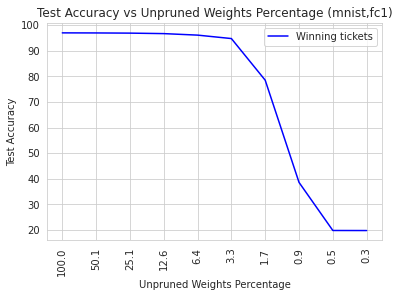

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
plt.plot(prune_iterations, best_acc, c="blue", label="Winning tickets") 
plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
plt.xlabel("Unpruned Weights Percentage") 
plt.ylabel("Test Accuracy") 
plt.xticks(prune_iterations, comp, rotation ="vertical") 
plt.legend() 
plt.show()
plt.close()

#Loading the dataset for testing the model

In [ ]:
#################
## Data Loader
#################
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

################################
## Loading the MNIST dataset
################################
if args.dataset == "mnist":
    traindataset = datasets.MNIST('../data', train = True, download = True, transform = transform)
    testdataset = datasets.MNIST('../data', train=False, transform = transform)

train_loader = torch.utils.data.DataLoader(traindataset, batch_size = args.batch_size, shuffle = True, num_workers = 0, drop_last = False)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, drop_last = True)

# Reload the best winning ticket obtained from main procedure

In [ ]:
final_model = copy.deepcopy(model.state_dict())
final_mask = copy.deepcopy(mask)

model = best_model

In [ ]:
def random_testing(model, input):    ## To input an image and get the predicted label from it
    test_loader = input
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    torch.no_grad()
    data = test_loader[0]
    data = data.to(device)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred
    return pred

# Fun part of the demo: Predictions on images

Enter a number between 0 and 9999: 999

Test input image from MNIST


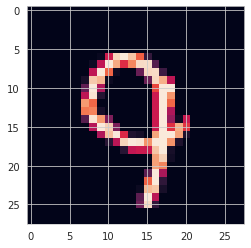

Actual label of the image:  tensor(9)
Predicted label by the winning ticket:  tensor([[9]], device='cuda:0')


In [ ]:
index_input = int(input("Enter a number between 0 and 9999: "))
image_input = testdataset[index_input]
print()
print("Test input image from MNIST")
plt.imshow(testdataset.data[index_input])
plt.show()

print("Actual label of the image: ", testdataset.targets[index_input])
print("Predicted label by the winning ticket: ", random_testing(model, image_input))
